In [1]:
# Standard libraries
import numpy as np
import json
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display
from time import time

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.metric.metric import MetricCalculator
from mesostat.stat.connectomics import offdiag_1D

from lib.sych.data_fc_db import DataFCDatabase

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data']  = gui_fpath("Path to data collection",  './')
params['root_path_data'] = '/media/alyosha/Data/TE_data/yarodata/neuro'

#params['root_path_paw']   = gui_fpath("Path to Paw data",         params['root_path_data'])
#params['root_path_lick']  = gui_fpath("Path to Lick data",        params['root_path_paw'])
#params['root_path_whisk'] = gui_fpath("Path to Whisk Data",       params['root_path_lick'])
# params['root_path_te']    = gui_fpath("Select TE results folder", params['root_path_data'])

In [3]:
dataDB = DataFCDatabase(params)

Target trial within [0, 8] sec. Total target timesteps 161
Searching for channel labels
Searching for data files
No paw path provided, skipping
No lick path provided, skipping
No whisk path provided, skipping


In [4]:
dataDB.read_te_files()
dataDB.read_neuro_files()
dataDB.read_resample_paw_files()
dataDB.read_resample_lick_files()   # Currently does not work. Ask Yaro if we need it
dataDB.read_resample_whisk_files()

No TE files loaded, skipping reading part


IntProgress(value=0, description='Read Neuro Data:', max=220)

Calculated performance 0.7264150943396226 does not match external 0.7333333333333333
Calculated performance 0.803680981595092 does not match external 0.808641975308642
Calculated performance 0.8411764705882353 does not match external 0.8436578171091446
Calculated performance 0.956989247311828 does not match external 0.9621621621621622
Calculated performance 0.6808510638297872 does not match external 0.6956521739130435
Calculated performance 0.9582366589327146 does not match external 0.9604651162790697
Calculated performance 0.4851258581235698 does not match external 0.4840182648401826
--Warning: For iMISS behaviour max index 437 exceeds nTrials 437
---Cropped excessive behaviour trials from 86 to 85
Calculated performance 0.42795389048991356 does not match external 0.6902017291066282
Calculated performance 0.2534562211981567 does not match external 0.30386740331491713
Calculated performance 0.4444444444444444 does not match external 0.47227191413237923
Calculated performance 0.56680161

--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyos

In [5]:
pTHR = 0.7
dataDB.mark_days_expert_naive(pTHR)

# Multi-Regional Metrics

* Measures of temporal relations
    - CrossCorrelation
    - CrossMI
    
### Important Questions

* Are connections significant compared to global state
* Can one undo global slow dynamics due to convolution to enhance connectivity
* 

## Cross-correlation

mtp_1 -0.5645826348260858 1.0
mtp_10 -0.6097332285050647 1.0
mtp_11 -0.457785667754224 1.0
mtp_12 -0.7547223273884041 1.0
mtp_13 -0.8178294003098434 1.0
mtp_15 -0.6986958903862107 1.0
mtp_16 -0.6587753440605868 1.0
mtp_2 -0.5349270769644149 1.0
mtp_7 -0.5788710236177467 1.0
mvg_2 -0.5911935406897836 1.0
mvg_3 -0.6081482695374829 1.0
mvg_4 -0.6140247874374509 1.0
mvg_5 -0.6651318446276864 1.0
mvg_6 -0.4242234994879687 1.0
mvg_7 -0.6742432426025292 1.0
mvg_8 -0.7769656184160101 1.0
mvg_9 -0.603591642173946 1.0


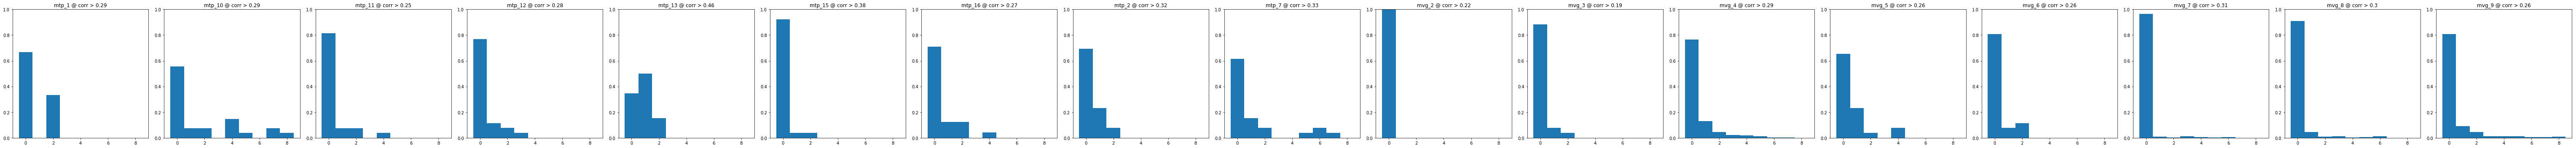

In [56]:
maxLag = 10
mc = MetricCalculator(serial=True, verbose=False)

fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice), 5), tight_layout=True)
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    rez = []
    for idx, row in rows.iterrows():
        mc.set_data(dataDB.dataNeuronal[idx], 'rsp', zscoreDim='p')
        rezThis = mc.metric3D('crosscorr', '', metricSettings=None, sweepSettings={'lag' : np.arange(maxLag)})
        rez += [rezThis]
        
    # Average over sessions
    rezMean = np.mean(rez, axis=0)
    rezMean = np.array([offdiag_1D(r) for r in rezMean])
    rezArgMax = np.argmax(np.abs(rezMean), axis=0)
    rezMax = np.max(np.abs(rezMean), axis=0)
    
    thrCut = np.quantile(rezMax, 0.8)
    idxCut = rezMax > thrCut
    
    print(mousename, np.min(rez), np.max(rez))
        
    ax[iMouse].set_title(mousename + ' @ corr > ' + str(np.round(thrCut, 2)))
#     ax[iMouse].plot(rezMax[idxCut], rezArgMax[idxCut], '.')
    ax[iMouse].hist(rezArgMax[idxCut], bins=np.arange(maxLag)-0.5, density=True)
    ax[iMouse].set_ylim([0, 1])
plt.show()

## Cross-Entropy

mtp_1_2015_06_18_b; took time 43.36609768867493
mtp_1_2015_06_19_b; took time 72.94808793067932
mtp_1_2015_06_22_b; took time 19.538447618484497
mtp_1_2015_06_23_b; took time 37.94386386871338
mtp_1_2015_06_24_a; took time 89.89673924446106
mtp_1_2015_06_25_a; took time 47.8915319442749
mtp_1_2015_06_26_a; took time 49.156407594680786
mtp_1_2015_07_14_a; took time 55.08830213546753
mtp_1_2015_07_15_a; took time 42.210054874420166
mtp_1 -0.0036203719462496496 4.080177317109046
mtp_10_2016_09_07_a; took time 299.36998438835144
mtp_10_2016_09_08_b; took time 8.721549987792969
mtp_10_2016_09_09_a; took time 14.917813777923584
mtp_10_2016_09_12_a; took time 73.72992730140686
mtp_10_2016_09_13_a; took time 155.08436274528503
mtp_10_2016_09_14_a; took time 145.58290696144104
mtp_10_2016_09_29_a; took time 163.22950410842896
mtp_10_2016_10_04_a; took time 126.93413186073303
mtp_10 0.0 4.435227639089334
mtp_11_2016_09_06_a; took time 51.08123850822449
mtp_11_2016_09_07_a; took time 106.29246139

Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    sel

KeyboardInterrupt: 

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


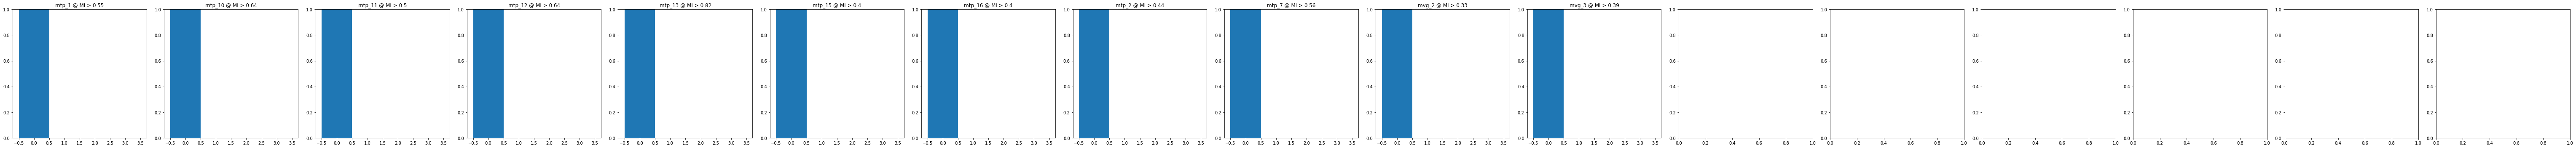

In [6]:
maxLag = 5
mc = MetricCalculator(serial=False, verbose=False)

fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice), 5), tight_layout=True)
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    rez = []
    for idx, row in rows.iterrows():
        t = time()
        print(row['mousekey'], end='')
        
        mc.set_data(dataDB.dataNeuronal[idx], 'rsp', zscoreDim='p')
        rezThis = mc.metric3D('cross_MI', '', metricSettings=None, sweepSettings={'lag' : np.arange(maxLag)})
        rez += [rezThis]
        
        print('; took time', time()-t)
        
    # Average over sessions
    rezMean = np.mean(rez, axis=0)
    rezMean = np.array([offdiag_1D(r) for r in rezMean])
    rezArgMax = np.argmax(np.abs(rezMean), axis=0)
    rezMax = np.max(np.abs(rezMean), axis=0)
    
    thrCut = np.quantile(rezMax, 0.8)
    idxCut = rezMax > thrCut
    
    print(mousename, np.min(rez), np.max(rez))
        
    ax[iMouse].set_title(mousename + ' @ MI > ' + str(np.round(thrCut, 2)))
#     ax[iMouse].plot(rezMax[idxCut], rezArgMax[idxCut], '.')
    ax[iMouse].hist(rezArgMax[idxCut], bins=np.arange(maxLag)-0.5, density=True)
    ax[iMouse].set_ylim([0, 1])
plt.show()

mvg_4 0.0 2.9048544858804775


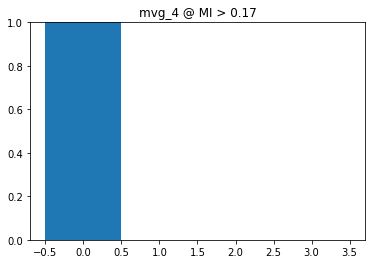

In [7]:
# Average over sessions
rezMean = np.mean(rez, axis=0)
rezMean = np.array([offdiag_1D(r) for r in rezMean])
rezArgMax = np.argmax(np.abs(rezMean), axis=0)
rezMax = np.max(np.abs(rezMean), axis=0)

thrCut = np.quantile(rezMax, 0.8)
idxCut = rezMax > thrCut

print(mousename, np.min(rez), np.max(rez))

plt.figure()
plt.title(mousename + ' @ MI > ' + str(np.round(thrCut, 2)))
#     ax[iMouse].plot(rezMax[idxCut], rezArgMax[idxCut], '.')
plt.hist(rezArgMax[idxCut], bins=np.arange(maxLag)-0.5, density=True)
plt.ylim([0, 1])
plt.show()